We are looking to predict and compute the frost point
============
Using the temperature and dewpoint

Therefore we will only aim to predict the temperature and dewpoint, to then compute the frost point

Using the following formula : 
## $T_f = T_d + \frac{2 671, 02}{\frac{2 954,61}{T} + 2,193665 \ln(T) - 13,3448} - T$

$T_f$ : the frost point temperature,
$T_d$ : the dewpoint temperature,
$T$ : the temperature.

In [ ]:
# Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet

In [2]:
df = pd.read_csv('climate_data.csv', sep=',')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      3902 non-null   object 
 1   Average temperature (°F)  3902 non-null   float64
 2   Average humidity (%)      3902 non-null   float64
 3   Average dewpoint (°F)     3902 non-null   float64
 4   Average barometer (in)    3902 non-null   float64
 5   Average windspeed (mph)   3902 non-null   float64
 6   Average gustspeed (mph)   3902 non-null   float64
 7   Average direction (°deg)  3902 non-null   float64
 8   Rainfall for month (in)   3902 non-null   float64
 9   Rainfall for year (in)    3902 non-null   float64
 10  Maximum rain per minute   3902 non-null   float64
 11  Maximum temperature (°F)  3902 non-null   float64
 12  Minimum temperature (°F)  3902 non-null   float64
 13  Maximum humidity (%)      3902 non-null   float64
 14  Minimum 

In [4]:
# Beginning of the data exploration and visualization
print(df.columns)

Index(['Date', 'Average temperature (°F)', 'Average humidity (%)',
       'Average dewpoint (°F)', 'Average barometer (in)',
       'Average windspeed (mph)', 'Average gustspeed (mph)',
       'Average direction (°deg)', 'Rainfall for month (in)',
       'Rainfall for year (in)', 'Maximum rain per minute',
       'Maximum temperature (°F)', 'Minimum temperature (°F)',
       'Maximum humidity (%)', 'Minimum humidity (%)', 'Maximum pressure',
       'Minimum pressure', 'Maximum windspeed (mph)',
       'Maximum gust speed (mph)', 'Maximum heat index (°F)', 'Date1', 'Month',
       'diff_pressure'],
      dtype='object')


First of all we notice that we've got among the features 5 different categories : Temperature, Humidity and Pressure, Wind, Rain, Time series.
In the temperature category we have :
- 'Average temperature (°F)'
- 'Maximum temperature (°F)'
- 'Minimum temperature (°F)'
- 'Maximum heat index (°F)'
- 'Average dewpoint (°F)'

In the Humidity and Pressure category :
- 'Average humidity (%)'
- 'Maximum humidity (%)' 
- 'Average barometer (in)'
- 'Minimum humidity (%)'
- 'Maximum pressure'
- 'Minimum pressure'
- 'diff_pressure'

In the Wind category : 
- 'Average windspeed (mph)'
- 'Average gustspeed (mph)'
- 'Maximum windspeed (mph)'
- 'Maximum gust speed (mph)
- 'Average direction (°deg)'

In the Rain category : 
- 'Rainfall for month (in)'
- 'Rainfall for year (in)' 
- 'Maximum rain per minute'

In Time : 
- 'Date1'
- 'Month'

In [5]:
print(df.describe())

       Average temperature (°F)  Average humidity (%)  Average dewpoint (°F)  \
count               3902.000000           3902.000000            3902.000000   
mean                  44.670733             48.878011              23.127037   
std                   15.326793             17.438153              14.634088   
min                  -12.100000              9.000000             -22.200000   
25%                   33.700000             36.000000              12.100000   
50%                   45.100000             47.000000              22.500000   
75%                   58.000000             61.000000              35.400000   
max                   76.300000             94.000000              55.100000   

       Average barometer (in)  Average windspeed (mph)  \
count             3902.000000              3902.000000   
mean                29.881420                 5.758893   
std                  0.250395                 4.022485   
min                 28.200000                 0

In [6]:
# Let's check for missing values
print(df.isna().sum())
# No missing values found, so we can proceed to explore the data


Date                        0
Average temperature (°F)    0
Average humidity (%)        0
Average dewpoint (°F)       0
Average barometer (in)      0
Average windspeed (mph)     0
Average gustspeed (mph)     0
Average direction (°deg)    0
Rainfall for month (in)     0
Rainfall for year (in)      0
Maximum rain per minute     0
Maximum temperature (°F)    0
Minimum temperature (°F)    0
Maximum humidity (%)        0
Minimum humidity (%)        0
Maximum pressure            0
Minimum pressure            0
Maximum windspeed (mph)     0
Maximum gust speed (mph)    0
Maximum heat index (°F)     0
Date1                       0
Month                       0
diff_pressure               0
dtype: int64


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
# We are going to convert the 'Date' column to a datetime format instead of 'object', it is going to make the reading of the x axis easier, since it is 
# correctly formated
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.set_index('Date', inplace = True)

In [10]:
df.head()

,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Average gustspeed (mph),Average direction (°deg),Rainfall for month (in),Rainfall for year (in),Maximum rain per minute,...,Maximum humidity (%),Minimum humidity (%),Maximum pressure,Minimum pressure,Maximum windspeed (mph),Maximum gust speed (mph),Maximum heat index (°F),Date1,Month,diff_pressure
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,37.8,35.0,12.7,29.7,26.4,36.8,274.0,0.0,0.0,0.0,...,4.0,27.0,29.762,29.596,41.4,59.0,40.0,2009-01-01,1,0.166
2009-01-02,43.2,32.0,14.7,29.5,12.8,18.0,240.0,0.0,0.0,0.0,...,4.0,16.0,29.669,29.268,35.7,51.0,52.0,2009-01-02,1,0.401
2009-01-03,25.7,60.0,12.7,29.7,8.3,12.2,290.0,0.0,0.0,0.0,...,8.0,35.0,30.232,29.260,25.3,38.0,41.0,2009-01-03,1,0.972
2009-01-04,9.3,67.0,0.1,30.4,2.9,4.5,47.0,0.0,0.0,0.0,...,7.0,35.0,30.566,30.227,12.7,20.0,32.0,2009-01-04,1,0.339
2009-01-05,23.5,30.0,-5.3,29.9,16.7,23.1,265.0,0.0,0.0,0.0,...,5.0,13.0,30.233,29.568,38.0,53.0,32.0,2009-01-05,1,0.665


In [11]:
df.nunique()

Average temperature (°F)     656
Average humidity (%)          86
Average dewpoint (°F)        637
Average barometer (in)        22
Average windspeed (mph)      206
Average gustspeed (mph)      332
Average direction (°deg)     328
Rainfall for month (in)      234
Rainfall for year (in)       799
Maximum rain per minute        1
Maximum temperature (°F)     680
Minimum temperature (°F)     577
Maximum humidity (%)          92
Minimum humidity (%)          89
Maximum pressure            1047
Minimum pressure            1062
Maximum windspeed (mph)       63
Maximum gust speed (mph)     104
Maximum heat index (°F)      626
Date1                       3902
Month                         12
diff_pressure               1028
dtype: int64

In [12]:
df.isnull().any()

Average temperature (°F)    False
Average humidity (%)        False
Average dewpoint (°F)       False
Average barometer (in)      False
Average windspeed (mph)     False
Average gustspeed (mph)     False
Average direction (°deg)    False
Rainfall for month (in)     False
Rainfall for year (in)      False
Maximum rain per minute     False
Maximum temperature (°F)    False
Minimum temperature (°F)    False
Maximum humidity (%)        False
Minimum humidity (%)        False
Maximum pressure            False
Minimum pressure            False
Maximum windspeed (mph)     False
Maximum gust speed (mph)    False
Maximum heat index (°F)     False
Date1                       False
Month                       False
diff_pressure               False
dtype: bool

In [13]:
print(df.describe().T.to_string())

                           count        mean        std     min      25%      50%       75%      max
Average temperature (°F)  3902.0   44.670733  15.326793 -12.100   33.700   45.100   58.0000   76.300
Average humidity (%)      3902.0   48.878011  17.438153   9.000   36.000   47.000   61.0000   94.000
Average dewpoint (°F)     3902.0   23.127037  14.634088 -22.200   12.100   22.500   35.4000   55.100
Average barometer (in)    3902.0   29.881420   0.250395  28.200   29.700   29.900   30.0000   31.000
Average windspeed (mph)   3902.0    5.758893   4.022485   0.000    2.700    4.600    8.0000   26.400
Average gustspeed (mph)   3902.0   10.011968  14.117446   0.000    4.500    7.100   12.1000  240.400
Average direction (°deg)  3902.0  216.037417  97.677761  -0.000  116.000  253.000  282.0000  360.000
Rainfall for month (in)   3902.0    0.451105   0.603462   0.000    0.050    0.220    0.6700    4.480
Rainfall for year (in)    3902.0    5.486171   4.534444   0.000    0.980    5.080    9.0475

<Axes: title={'center': 'Rolling Mean of Average Humidity (%)'}, xlabel='Date', ylabel='Average Humidity (%)'>

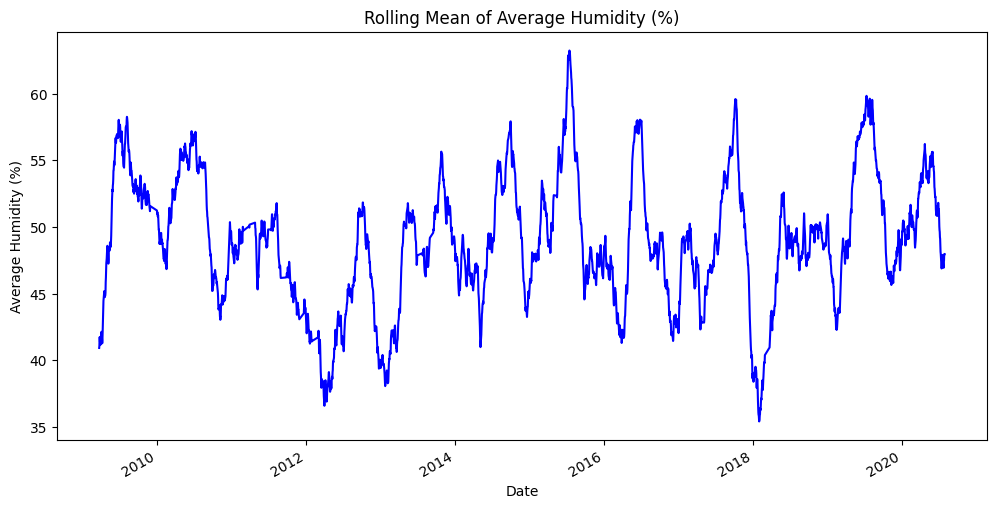

In [14]:
df['Average humidity (%)'].rolling(window=80).mean().plot(figsize=(12, 6), title='Rolling Mean of Average Humidity (%)', color='blue', xlabel='Date', ylabel='Average Humidity (%)')

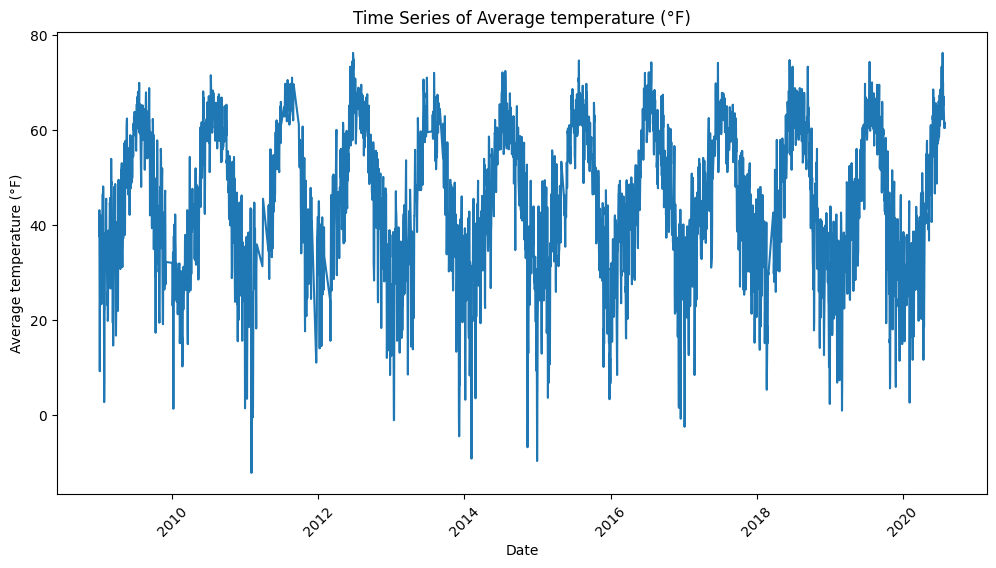

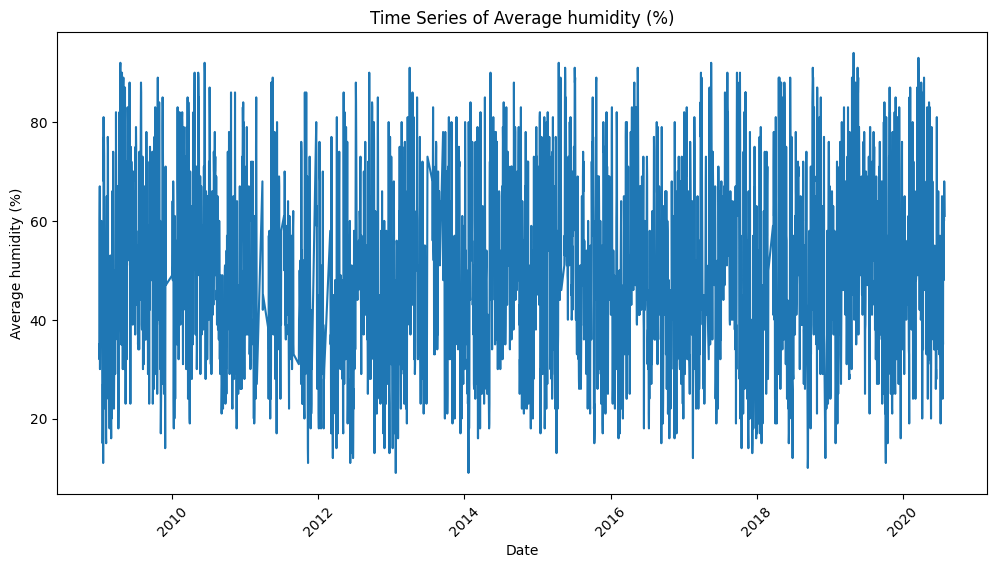

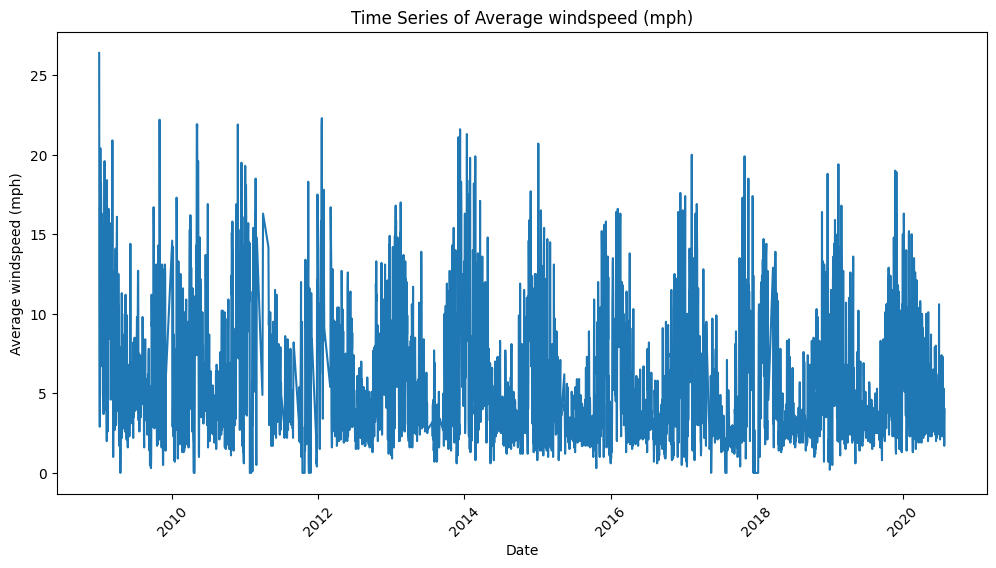

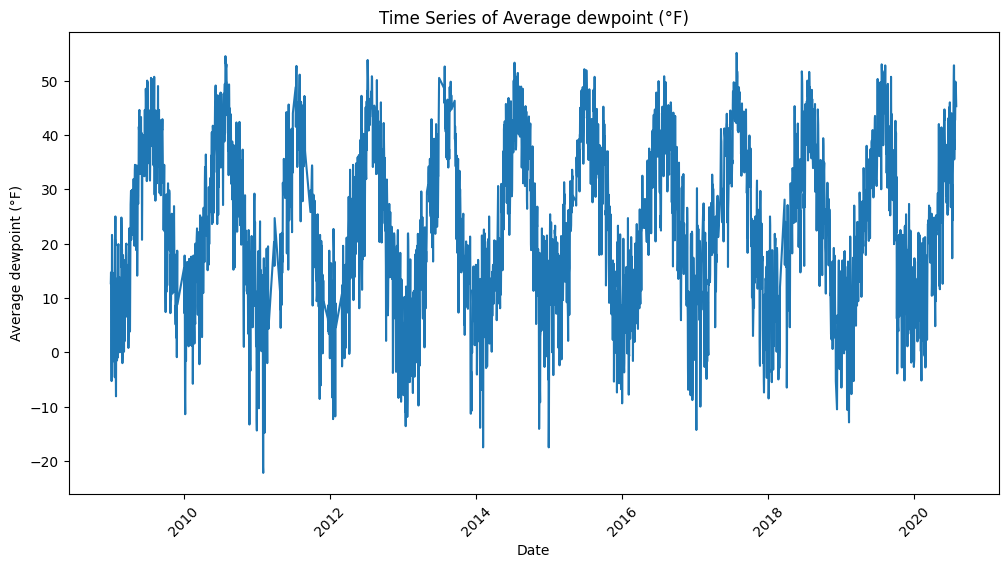

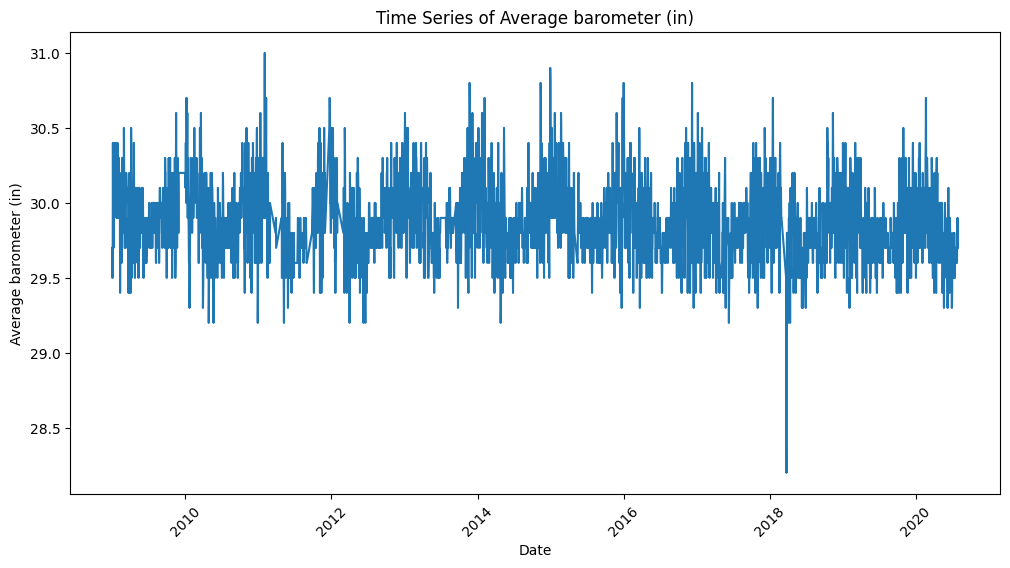

In [15]:
# Let's plot a few features to visualize their distributions and check for outliers
features_to_plot = ['Average temperature (°F)', 'Average humidity (%)', 'Average windspeed (mph)', 'Average dewpoint (°F)', 'Average barometer (in)']

# As not all features have the same measurement units, we will create separate plots for each feature
# We use the Date feature as x-axis for time series plots
for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Date', y=feature)
    plt.title(f'Time Series of {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()

We can notice some very evident patern in each plot, which is a good sign since the seasons don't vary a lot from to year

We notice that some variables have some very strong correlations where as others don't. We will take a look at every features having a correlation superior to 0.4 or inferior to -0.4

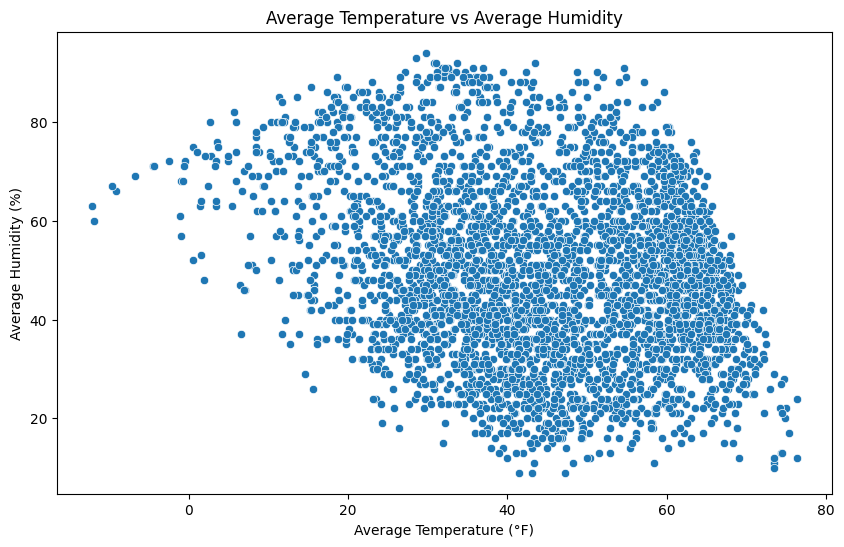

In [16]:
# Now let's try to analyse the relationships between features, temperature vs humidity for example
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Average temperature (°F)', y='Average humidity (%)')
plt.title('Average Temperature vs Average Humidity')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Average Humidity (%)')
plt.show()


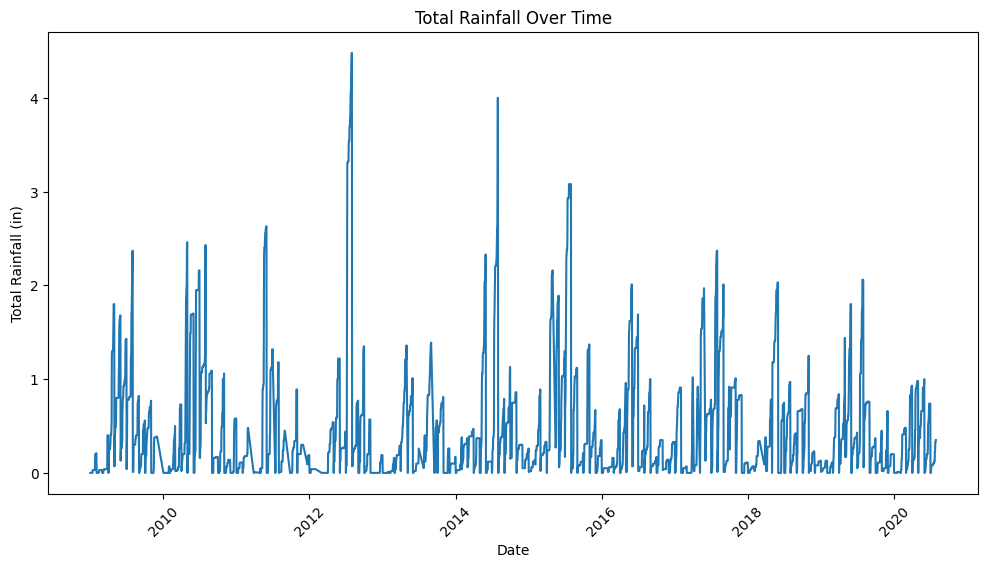

In [17]:
# We try to visualize the evolution of rainfall over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Rainfall for month (in)')
plt.title('Total Rainfall Over Time')
plt.xlabel('Date')
plt.ylabel('Total Rainfall (in)')
plt.xticks(rotation=45)
plt.show()

Simply to take a look at the rainfall data of the dataset, we notice an evident seasonality, which is inline with the patern of the dewpoint overtime. We will have to check wether these two variables are correlated or if they are simply influenced by the same factor : seasonality. 

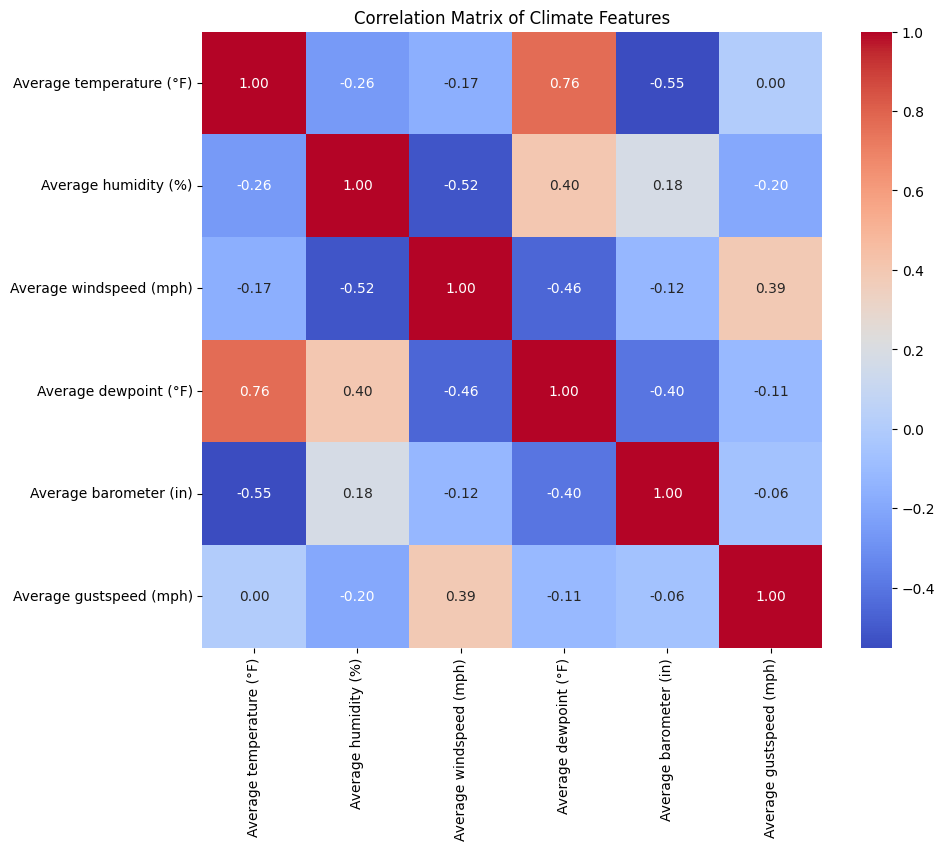

In [18]:
# Now we can look for correlations between features
features_to_plot = ['Average temperature (°F)', 
                    'Average humidity (%)', 
                    'Average windspeed (mph)', 
                    'Average dewpoint (°F)', 
                    'Average barometer (in)', 
                    'Average gustspeed (mph)'
                   ]
plt.figure(figsize=(10, 8))
correlation_matrix = df[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Features')
plt.show()

In [19]:
df = df.drop('Average direction (°deg)', axis=1)

In [20]:
print(df.columns)

Index(['Average temperature (°F)', 'Average humidity (%)',
       'Average dewpoint (°F)', 'Average barometer (in)',
       'Average windspeed (mph)', 'Average gustspeed (mph)',
       'Rainfall for month (in)', 'Rainfall for year (in)',
       'Maximum rain per minute', 'Maximum temperature (°F)',
       'Minimum temperature (°F)', 'Maximum humidity (%)',
       'Minimum humidity (%)', 'Maximum pressure', 'Minimum pressure',
       'Maximum windspeed (mph)', 'Maximum gust speed (mph)',
       'Maximum heat index (°F)', 'Date1', 'Month', 'diff_pressure'],
      dtype='object')


From this correlation matrix we get some interesting conclusions. We will be selecting the features that are above 0.4 and under -0.4. 

Therefore we get that for predicting the dewpoint we need: 
- temperature
- humidity
- windspeed
- barometer

The average direction of the wind isn't correlated enough to be taken into consideration.
Let's now look at other features and compare them to the dewpoint to make sure we don't leave some important information behind

<Axes: title={'center': 'Rolling Mean of Average Gutspeed'}, xlabel='Date', ylabel='Average Humidity (%)'>

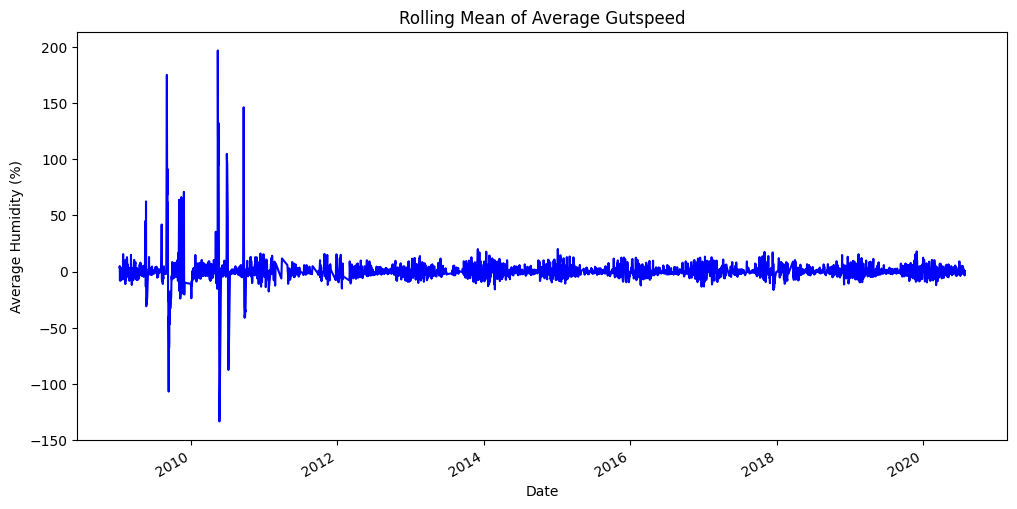

In [21]:
# Let's now see if the gutspeed feature is useful for our prediction
(df['Average gustspeed (mph)']- df['Average gustspeed (mph)'].rolling(window=10).mean()).plot(figsize=(12, 6), title='Rolling Mean of Average Gutspeed', color='blue', xlabel='Date', ylabel='Average Humidity (%)')

Although early data (pre-2012) contains significant volatility and extreme spikes, possibly indicating noisy or irregular measurements. From 2012 onward, the feature’s values become more consistent and less erratic, staying closer to the mean.

The more stable post-2012 period suggests the gustspeed feature could be a reliable input to a predictive model, but its overall predictive power should be validated statistically, ensuring spikes do not dominate signal detection.

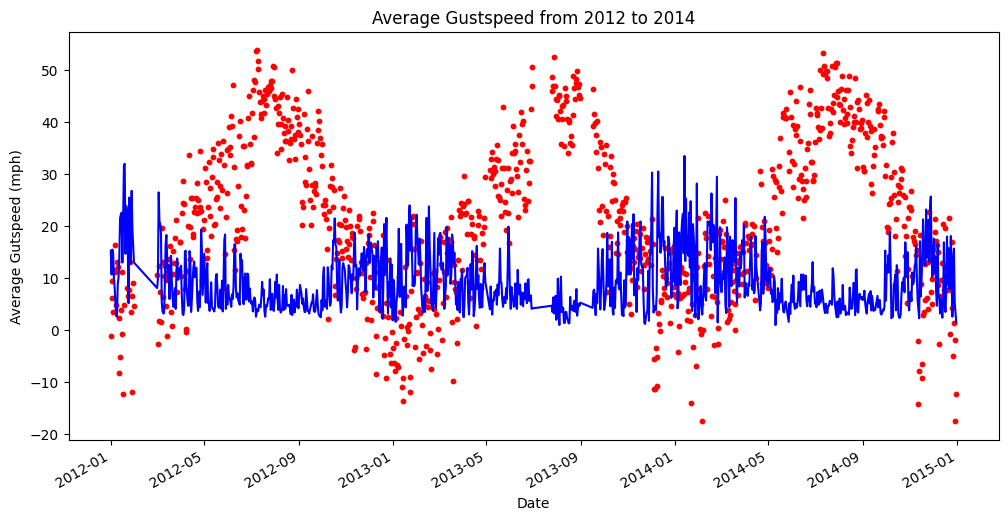

In [22]:
df.loc['2012':'2014', 'Average gustspeed (mph)'].plot(
    figsize=(12, 6), 
    title='Average Gustspeed from 2012 to 2014', 
    color='blue', 
    xlabel='Date', 
    ylabel='Average Gutspeed (mph)'
)
plt.scatter(x=df.loc['2012':'2014'].index, y=df.loc['2012':'2014', 'Average dewpoint (°F)'], color='red', s=10)
plt.show()

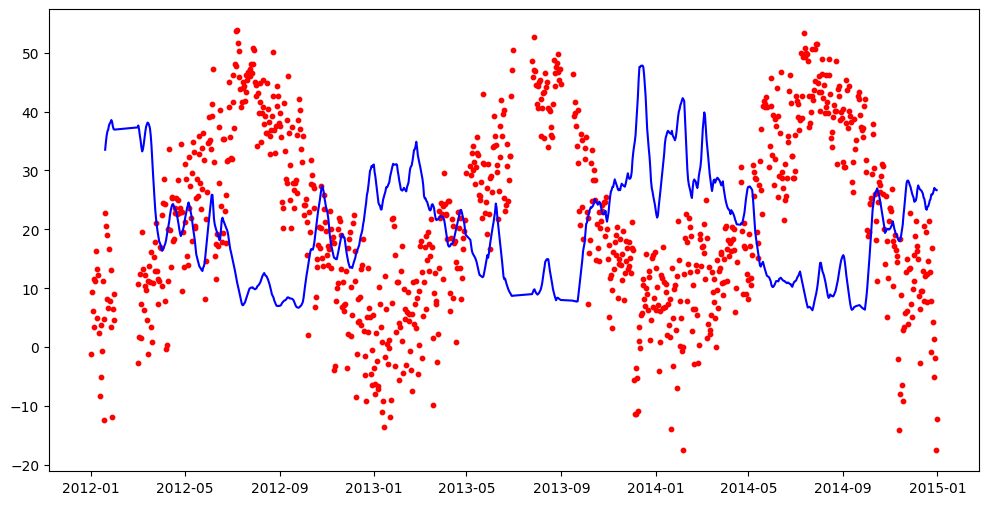

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df.loc['2012':'2014'].index, y=df.loc['2012':'2014', 'Average dewpoint (°F)'], color='red', s=10)
plt.plot(df.loc['2012':'2014'].index, (df.loc['2012':'2014', 'Average gustspeed (mph)'].rolling(window=10).std()*5).rolling(window=10).mean(), color='blue')

From these two graphs, it seems that the gutspeed is invertly correlated to the average dewpoint. High variations of gutspeed over the last few days result in a lower temperature for the dewpoint. The gutspeed is also subject to high seasonality which is great for prediction models like SARIMA. We can keep the average gutspeed as a parameter for predicting the dewpoint. 

Let's now take a look at the cumulative rainfall for a month up to that date.

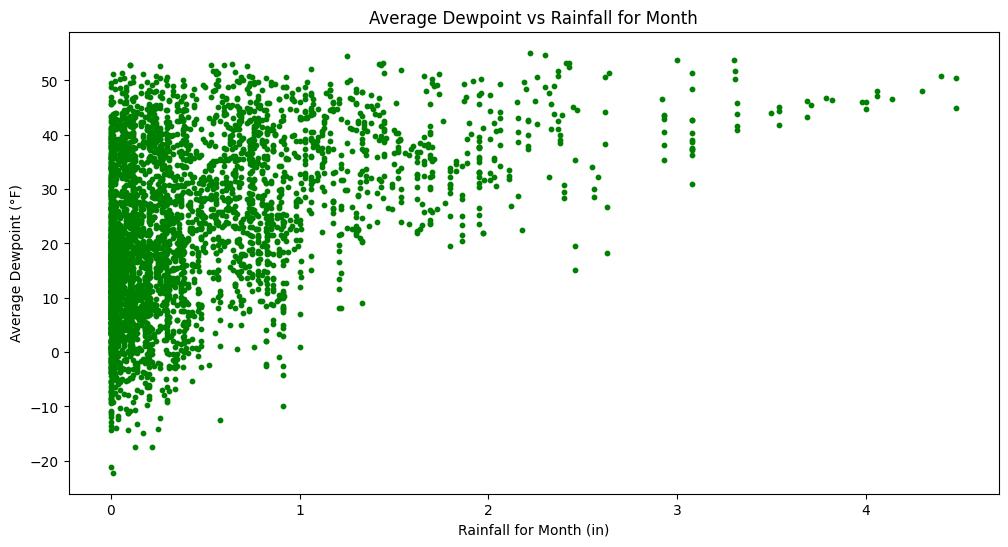

In [24]:
# We are going to proceed the same way for the rainfall feature, looking for correlations with the dewpoint
plt.figure(figsize=(12, 6))
plt.scatter(x=df['Rainfall for month (in)'], y=df['Average dewpoint (°F)'], color='green', s=10)
plt.title('Average Dewpoint vs Rainfall for Month')
plt.xlabel('Rainfall for Month (in)')
plt.ylabel('Average Dewpoint (°F)')
plt.show()

Although this graph lets us see that there is a clear limit, which is that the average dewpoint can only stay in the upper diagonal half of the graph, it can't seem to cross a line.
In addition the graph is just a messy cloud without a clear pattern for predicting the dewpoint. Rainfall per month doesn't seem to cut it, nor per year.

Now lets look at the maximum temperature and minimum temperature features, and use them to create a new 'variation' feature, which could be useful for predicting the dewpoint. If looks promising we will do the same for humidity and pressure. 

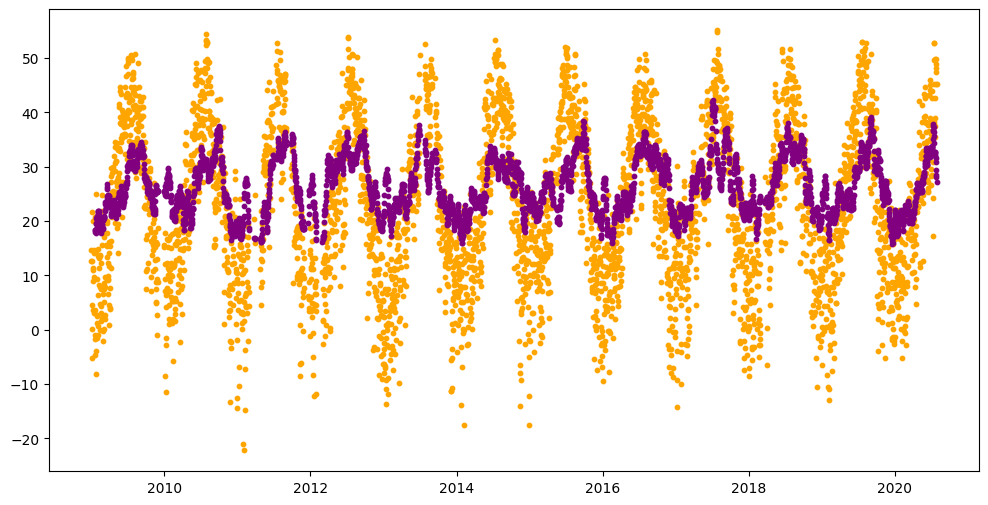

In [25]:
diff_temp = df['Maximum temperature (°F)'] - df['Minimum temperature (°F)']
plt.figure(figsize=(12, 6))
plt.scatter(x=df.index, y=df['Average dewpoint (°F)'], color='orange', s=10)
plt.scatter(x=df.index, y=diff_temp.rolling(window=20).mean(), color='purple', s=10)
plt.show()

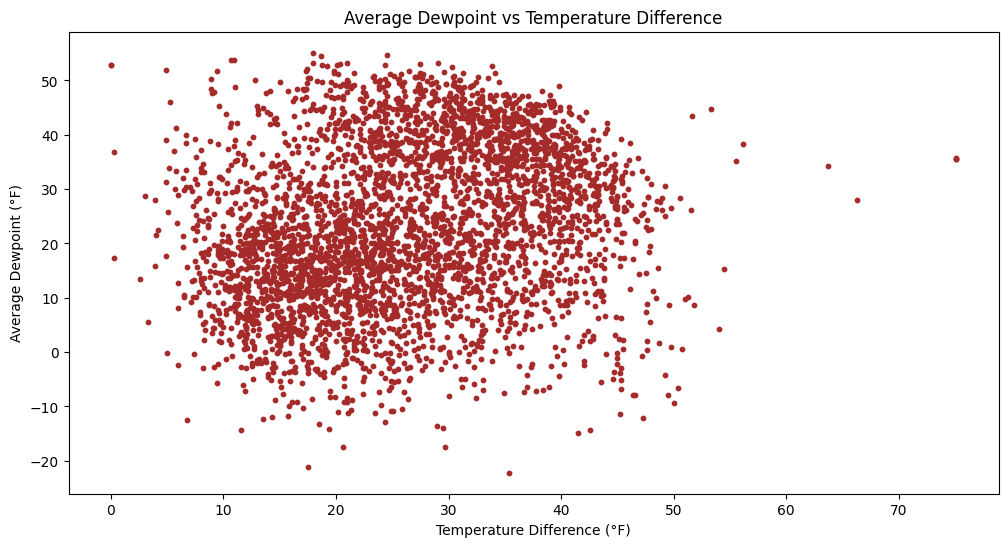

In [26]:
# Lets plot the scatter plot of dewpoint vs temperature difference
plt.figure(figsize=(12, 6))
plt.scatter(x=diff_temp, y=df['Average dewpoint (°F)'], color='brown', s=10)
plt.title('Average Dewpoint vs Temperature Difference')
plt.xlabel('Temperature Difference (°F)')
plt.ylabel('Average Dewpoint (°F)')
plt.show()

From this scatter plot we get a very important information: there is no real correlation between the difference in temperature and the average dewpoint. Although previous plot showed that they followed the same seasonal trend, it was misleading. The lack of pattern in the second graph confirms that both features are driven by the same "hidden" variable, namely to say : the season. The difference of temperature during the day has no real effect on the dewpoint temperature. 

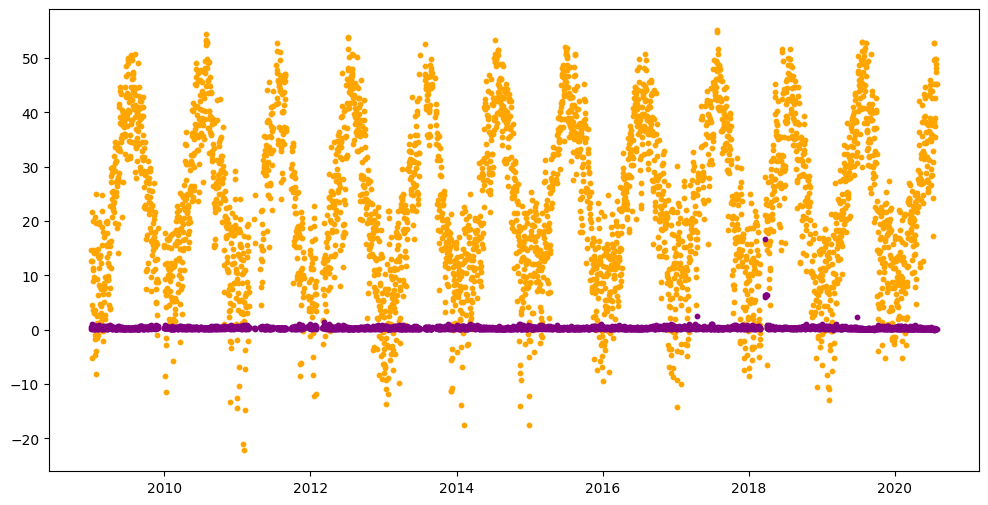

In [27]:
diff_pressure = df['Maximum pressure'] - df['Minimum pressure']
plt.figure(figsize=(12, 6))
plt.scatter(x=df.index, y=df['Average dewpoint (°F)'], color='orange', s=10)
plt.scatter(x=df.index, y=diff_pressure, color='purple', s=10)
plt.show()

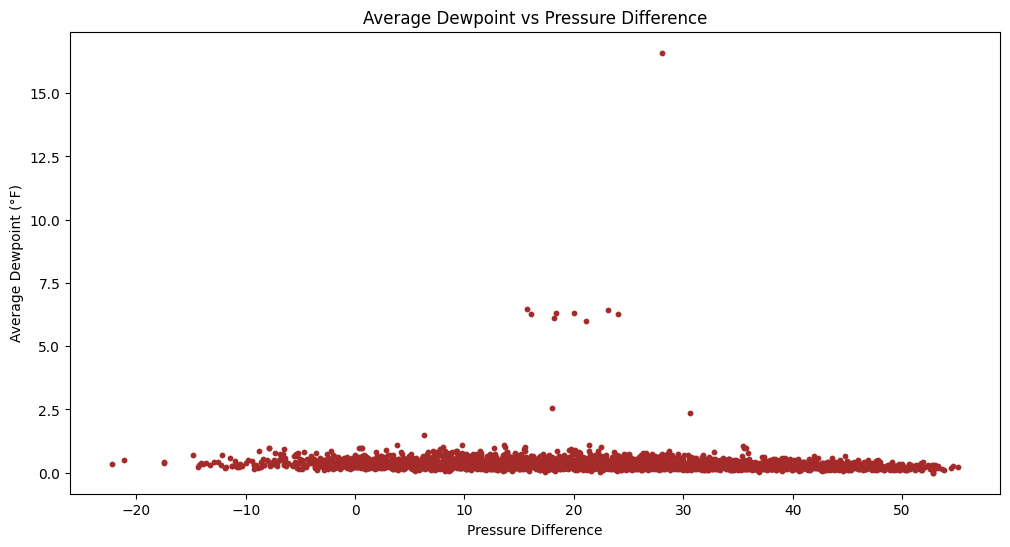

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(y=diff_pressure, x=df['Average dewpoint (°F)'], color='brown', s=10)
plt.title('Average Dewpoint vs Pressure Difference')
plt.xlabel('Pressure Difference')
plt.ylabel('Average Dewpoint (°F)')
plt.show()

Pressure difference doesn't seem to be of any use. 

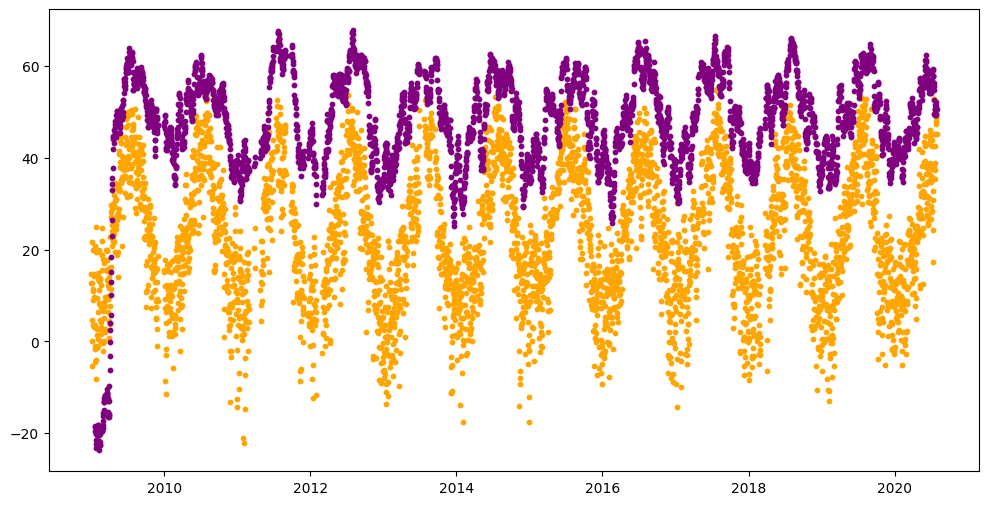

In [29]:
diff_humidity = df['Maximum humidity (%)'] - df['Minimum humidity (%)']
plt.figure(figsize=(12, 6))
plt.scatter(x=df.index, y=df['Average dewpoint (°F)'], color='orange', s=10)
plt.scatter(x=df.index, y=diff_humidity.rolling(window=20).mean(), color='purple', s=10)
plt.show()

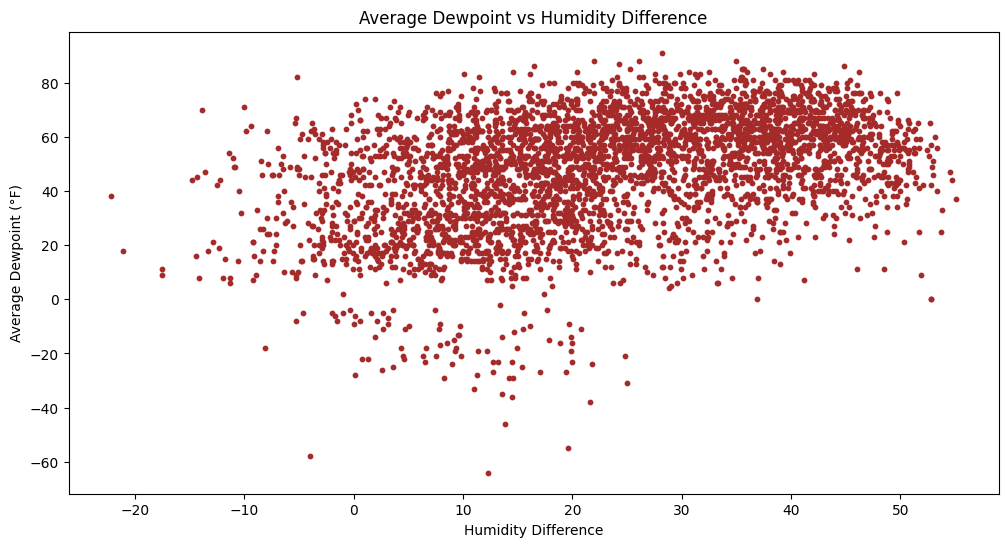

In [30]:
plt.figure(figsize=(12, 6))
plt.scatter(y=diff_humidity, x=df['Average dewpoint (°F)'], color='brown', s=10)
plt.title('Average Dewpoint vs Humidity Difference')
plt.xlabel('Humidity Difference')
plt.ylabel('Average Dewpoint (°F)')
plt.show()

Once again the scatter plot doesn't show any trend between the humidity difference and average dewpoint. Both features are indeed subject to the same seasonality but are not correlated.

In [31]:

df_final = df[['Average temperature (°F)', 'Average humidity (%)', 'Average windspeed (mph)', 'Average gustspeed (mph)', 'Average barometer (in)', 'Average dewpoint (°F)']]
df_final.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3902 entries, 2009-01-01 to 2020-07-28
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Average temperature (°F)  3902 non-null   float64
 1   Average humidity (%)      3902 non-null   float64
 2   Average windspeed (mph)   3902 non-null   float64
 3   Average gustspeed (mph)   3902 non-null   float64
 4   Average barometer (in)    3902 non-null   float64
 5   Average dewpoint (°F)     3902 non-null   float64
dtypes: float64(6)
memory usage: 342.4 KB


In [32]:
df_final = df_final.asfreq('D')

In [33]:
df_final.isnull().sum()

Average temperature (°F)    325
Average humidity (%)        325
Average windspeed (mph)     325
Average gustspeed (mph)     325
Average barometer (in)      325
Average dewpoint (°F)       325
dtype: int64

There are in the dataset, missing dates. Some days do not appear so we need to create new lines and fill the lines with new values. We can use the fillna method from pandas to do so.

In [34]:
df_final = df_final.fillna(method='ffill')
print(df_final.isna().sum())

Average temperature (°F)    0
Average humidity (%)        0
Average windspeed (mph)     0
Average gustspeed (mph)     0
Average barometer (in)      0
Average dewpoint (°F)       0
dtype: int64


/var/folders/l0/3sqfqq3x0ns21slz_gg1wc8w0000gn/T/ipykernel_20759/1894701398.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final = df_final.fillna(method='ffill')


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

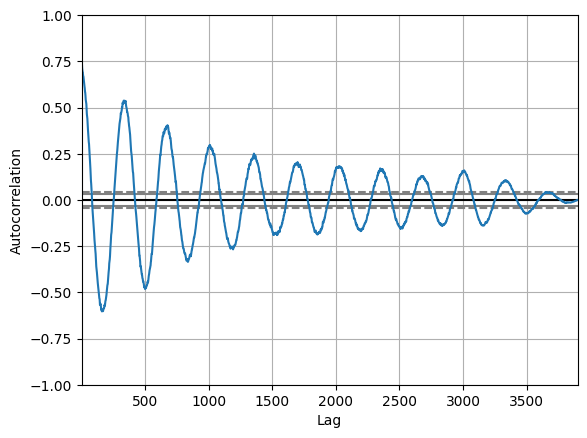

In [ ]:
autocorrelation_plot(df['Average temperature (°F)'])

From the graph we get that, there is seasonality. A damped sinusoidal wave is seen with a through around every 350-400 lags

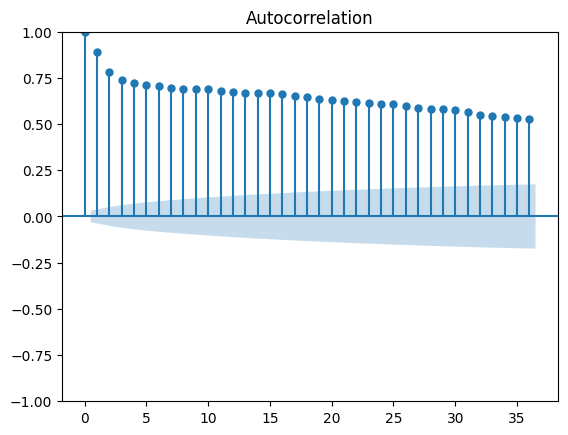

In [ ]:
plot_acf(df['Average temperature (°F)'])
plt.show()

ACF plots show the correlation between a time series and a lagged version of itself. The ACF graph is decreasing exponentially.

Time series decomposition is a statistical technique that involves breaking down a time series into its underlying components to better understand its patterns and improve forecasting accuracy. The most common components of a time series are trend, seasonality, and remainder.

In [ ]:
columns = df_final.columns
maxlag = 12
test = 'ssr_chi2test'

cause = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)

for column in columns:
    
    #For loop to fill the rows of the causality, in conjunction with the column
    for row in columns:
        causality = grangercausalitytests(df_final[[row, column]], maxlag = maxlag,verbose = False) #Calculate causality values
        pValues = [round(causality[i+1][0][test][1],5) for i in range(maxlag)] #Collect all the p values in the max lag
        minValue = np.min(pValues) #Take the smallest P value
        cause.loc[row, column] = minValue
cause.head(7)

/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/henri/mi

,Average temperature (°F),Average humidity (%),Average windspeed (mph),Average gustspeed (mph),Average barometer (in),Average dewpoint (°F)
Average temperature (°F),1.0,0.0,0.00000,0.00000,0.0,0.00000
Average humidity (%),0.0,1.0,0.00121,0.47894,0.0,0.00000
Average windspeed (mph),0.0,0.0,1.00000,0.09681,0.0,0.00000
Average gustspeed (mph),0.0,0.0,0.00000,1.00000,0.0,0.01392
Average barometer (in),0.0,0.0,0.00000,0.00329,1.0,0.00000
Average dewpoint (°F),0.0,0.0,0.00000,0.00000,0.0,1.00000


There is very little connection between these variables. That means VAR (Vector Auto Regression model) is not useful here. I am also not looking for one variable specifically, so a regular regression does not fit here. Thus, we will use ARIMA.

In [38]:
print(df_final.isnull().sum())

Average temperature (°F)    0
Average humidity (%)        0
Average windspeed (mph)     0
Average gustspeed (mph)     0
Average barometer (in)      0
Average dewpoint (°F)       0
dtype: int64


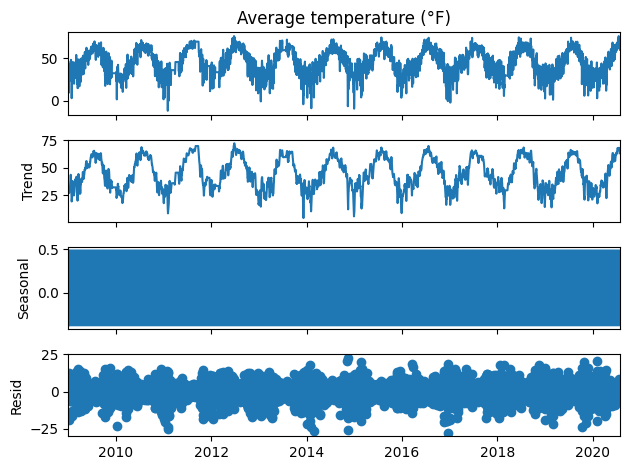

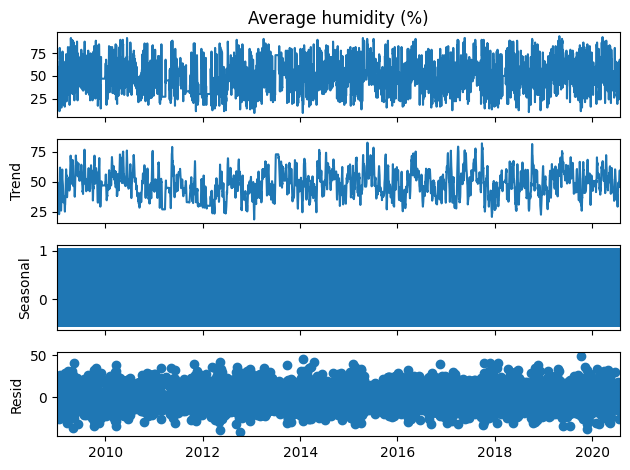

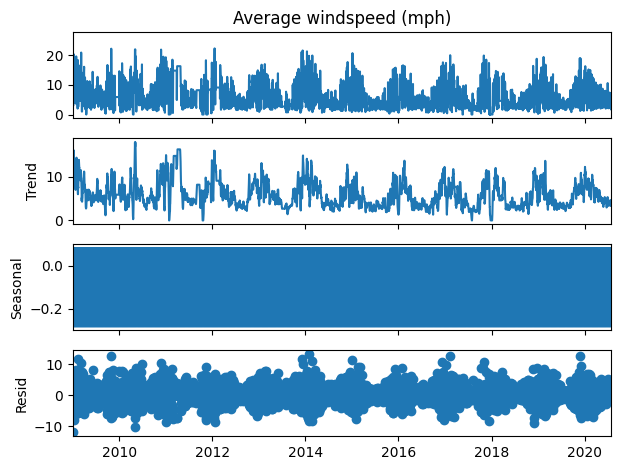

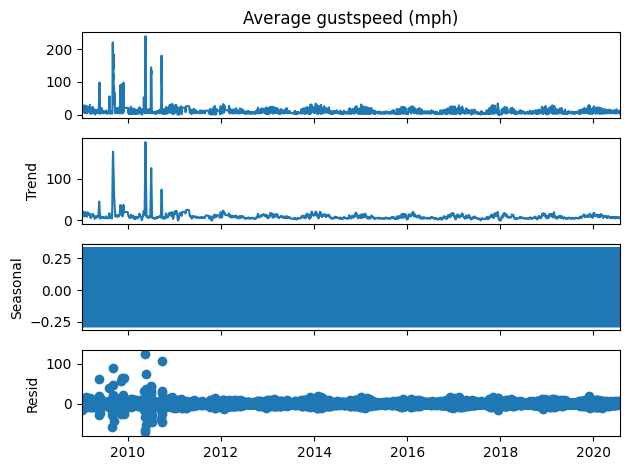

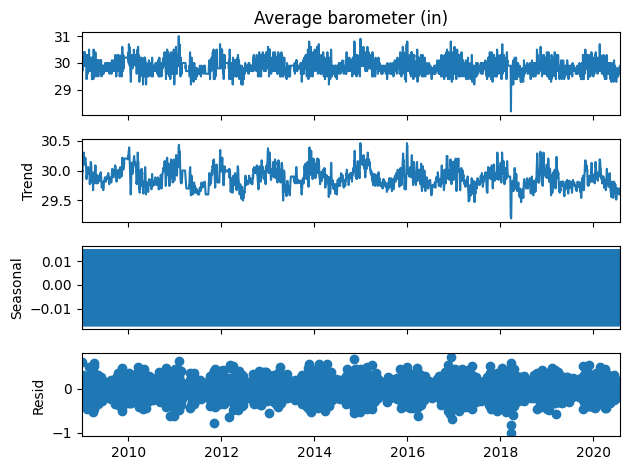

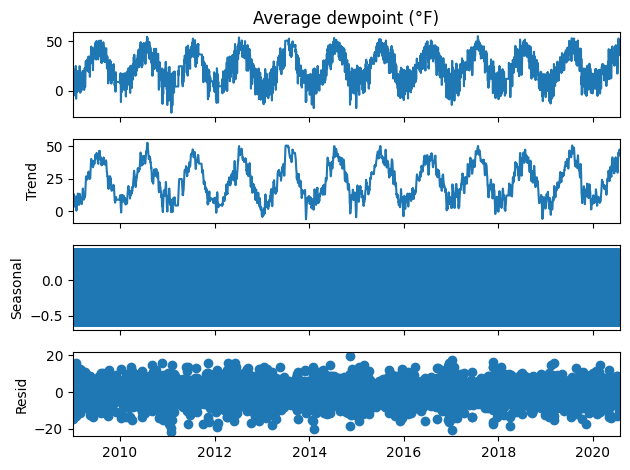

In [ ]:
for column in columns:
    decomposed = seasonal_decompose(x=df_final[column])
    x = decomposed.plot()
    plt.show()

In [ ]:
#Do the ADFuller test for each column
for column in columns:
    adf = adfuller(df_final[column]) #Call adfuller to test
    print("ADF test static for {} is {}".format(column, adf[1])) #Print the adfuller results

ADF test static for Average temperature (°F) is 0.00011995140074475764
ADF test static for Average humidity (%) is 4.37472907786058e-26
ADF test static for Average windspeed (mph) is 6.909924882774302e-17
ADF test static for Average gustspeed (mph) is 4.60183807614741e-26
ADF test static for Average barometer (in) is 2.409671769466264e-07
ADF test static for Average dewpoint (°F) is 0.002177238107136307


We get that the data is stationary

# Let's proceed to the prediction part of the study

 Now that we have our features selected, we aim to test different prediction models. We will be testing out Facebook Prophet, the Seasonal Auto Regressive Integrated Moving Average (SARIMA), the Exponential Smoothing Model (ESM), the Vector Autoregression Model (VAR), and perhaps other models like Recurrent Neural Networks and Long Short-Term Memory.

In [ ]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = df['Date1']
df_prophet['y'] = df['Average dewpoint (°F)']

train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
model = Prophet()
model.fit(train) # Use the full dataset minus the last 30 days

# We now want to make future predictions for the next month
future = test[['ds']].copy()
print('Future dates', future.head())
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

/Users/henri/miniconda3/envs/Forecast/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
08:40:58 - cmdstanpy - INFO - Chain [1] start processing
08:40:58 - cmdstanpy - INFO - Chain [1] done processing


Future dates                     ds
Date                  
2020-06-29  2020-06-29
2020-06-30  2020-06-30
2020-07-01  2020-07-01
2020-07-02  2020-07-02
2020-07-03  2020-07-03


,ds,yhat,yhat_lower,yhat_upper
19,2020-07-18,44.623367,35.190632,54.067379
20,2020-07-19,44.510687,35.820526,53.484490
21,2020-07-20,44.310804,35.086203,53.298164
22,2020-07-21,43.758954,34.146389,53.300597
23,2020-07-22,44.370128,35.055239,54.081988
24,2020-07-23,44.726053,34.636665,53.648728
25,2020-07-24,44.886960,34.690488,54.202314
26,2020-07-25,44.541635,35.518680,53.846494
27,2020-07-26,44.279507,34.806872,54.016074
28,2020-07-27,43.941974,34.877790,53.630433


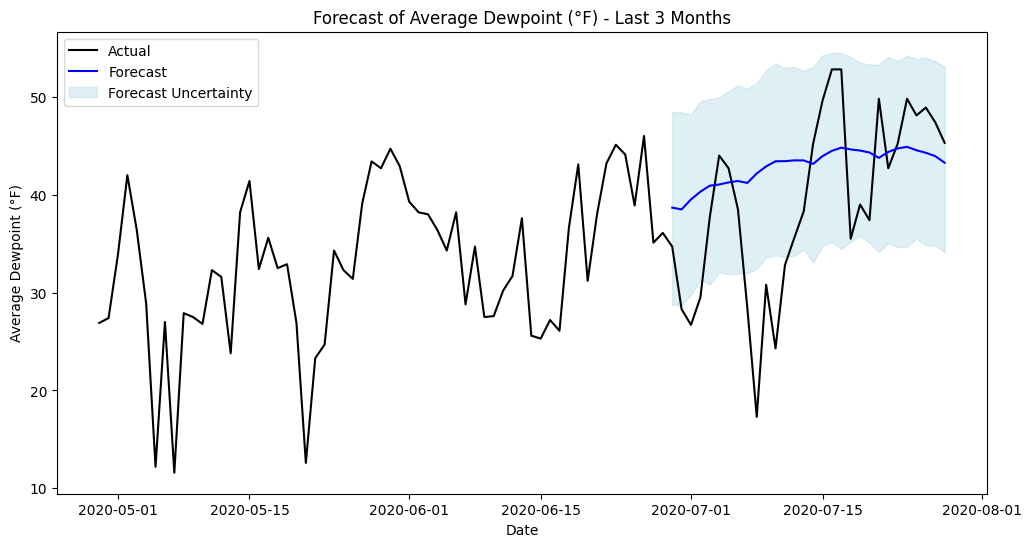

In [41]:
# Get min and max dates for last 3 months in your data
last_date = df_prophet['ds'].max()
three_months_ago = last_date - pd.Timedelta(days=90)

# Filter the forecast and original data to last 3 months
forecast_last3m = forecast[forecast['ds'] >= three_months_ago]
actual_last3m = df_prophet[df_prophet['ds'] >= three_months_ago]

# Plot the forecast and the actual values together
plt.figure(figsize=(12, 6))
plt.plot(actual_last3m['ds'], actual_last3m['y'], label='Actual', color='black')
plt.plot(forecast_last3m['ds'], forecast_last3m['yhat'], label='Forecast', color='blue')
plt.fill_between(
    forecast_last3m['ds'],
    forecast_last3m['yhat_lower'],
    forecast_last3m['yhat_upper'],
    color='lightblue',
    alpha=0.4,
    label='Forecast Uncertainty'
)
plt.title('Forecast of Average Dewpoint (°F) - Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Average Dewpoint (°F)')
plt.legend()
plt.show()


In [ ]:
# Let's see the accuracy of our model


# Assume 'test' contains actual values for the last 30 days and 'forecast' contains predictions for the same
results = test.copy()
results['ds'] = pd.to_datetime(results['ds'])
forecast_copy = forecast.copy()
forecast_copy['ds'] = pd.to_datetime(forecast_copy['ds'])

merged = results[['ds', 'y']].merge(
    forecast_copy[['ds', 'yhat']],
    on='ds'
)

mae = mean_absolute_error(merged['y'], merged['yhat'])
mse = mean_squared_error(merged['y'], merged['yhat'])
mape = (abs(merged['y'] - merged['yhat']) / merged['y']).mean() * 100

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')



Mean Absolute Error: 7.11
Mean Squared Error: 79.06
Mean Absolute Percentage Error: 23.14%


these results aren't very convincing let's try another method

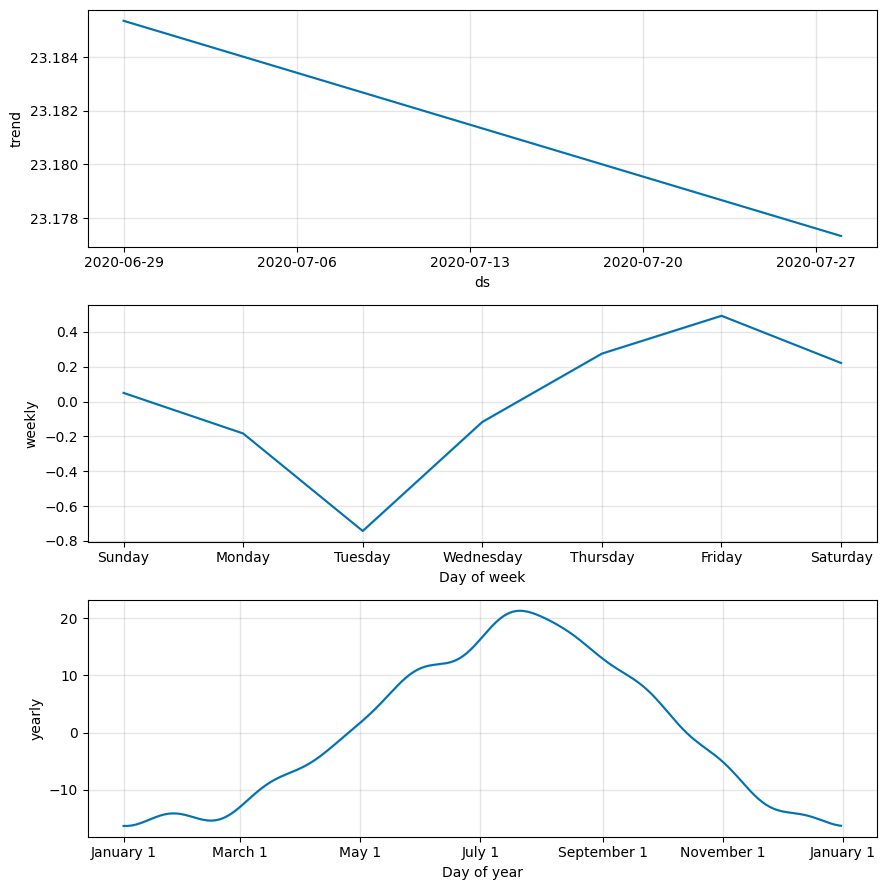

In [43]:
fig2 = model.plot_components(forecast)

In [ ]:
length = int((len(df_final)*9) /10)
print(length)
train_data = df_final[:length]
test_data = df_final[length:]
dewpoint = test_data['Average dewpoint (°F)']
test_data = test_data.drop('Average dewpoint (°F)', axis=1)

3804


In [ ]:
model = SARIMAX(train_data["Average dewpoint (°F)"], train_data.drop(columns = {"Average dewpoint (°F)"})) #Build the SARIMAX model
fitModel = model.fit(disp = 1) #Fit the SARIMAx model

Text(0, 0.5, 'Temperature (F)')

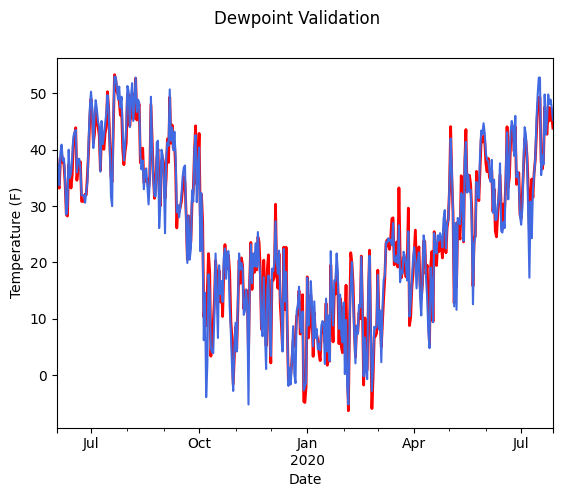

In [ ]:
forecast = fitModel.forecast(len(df_final) - length, exog = test_data.values) #Forecast for validation data
ax = forecast.plot(subplots = True, color = "red", linewidth = 2, title = "Dewpoint Validation") #Plot the forecasted data
dewpoint.plot(ax = ax, subplots = True, color = "royalblue") #Plot the actual dewpoint
plt.ylabel("Temperature (F)")

In [52]:
print("The Absolute Error of {} is {}".format("Dewpoint", mean_absolute_error(dewpoint, forecast)))

The Absolute Error of Dewpoint is 1.885042520711309


The error amount is quite small, so the model will do fine

We can now proceed to build the full model for the future prediction

In [54]:
modelPred = SARIMAX(df_final["Average dewpoint (°F)"], df_final.drop(columns = {"Average dewpoint (°F)"})) #Build the prediction model
fitModelPred = modelPred.fit(disp = 1)

In [55]:

df_final_NoDew = df_final.drop(columns = {"Average dewpoint (°F)"}) #Get the weather data without the dewpoint
weatherNoDew = df_final_NoDew[len(df_final) - 365:] #Limit the size so I can see it better in the graph
dewShort = dewpoint[len(dewpoint)-365:]

Text(0, 0.5, 'Temperature (F)')

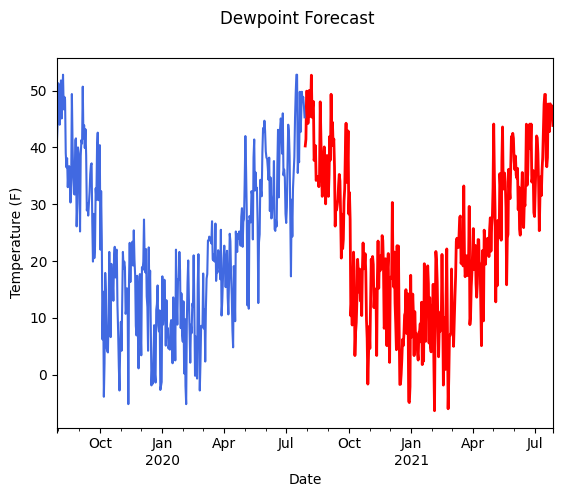

In [56]:
forecastDew = fitModelPred.forecast(steps = len(weatherNoDew), exog = weatherNoDew.values) #Forecast the next year
ax = forecastDew.plot(subplots = True, color = "red", linewidth = 2, title = "Dewpoint Forecast") #Plot the dew forecast
dewShort.plot(ax = ax, subplots = True, color = "royalblue") #Plot the shortened dew dataframe
plt.ylabel("Temperature (F)") #Put the temperature label